## Affect on accuracy with noise

In [4]:
#  imports
import os
import numpy as np
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('../')

from chromagram import fetch_chromagram
from DTW import dtw_table, dtw, display_dtw_path, similarity_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

### add noise to audio file tests

In [6]:
import os
from tqdm import tqdm

import numpy as np
import librosa

import soundfile as sf

In [7]:
def add_noise(file_path, save_folder=None, SNR=15, verbose=False):
    file_name = os.path.basename(file_path)
    save_folder = save_folder if save_folder is not None else os.path.dirname(file_path)+'/'
    save_name = file_name[:-4]+"_SNR_"+str(SNR)+file_name[-4:]
    
    signal, sr = librosa.load(file_path, sr=None)
    
    RMS_signal = np.sqrt(np.mean(signal**2))
    RMS_noise = np.sqrt(RMS_signal**2 / (10**(SNR/10)))
    
    noise = np.random.normal(0, RMS_noise, signal.shape[0])
    
    noisy_signal = signal + noise
    sf.write(save_folder+save_name, noisy_signal, sr)
    if verbose:
        print("saved to: ", save_folder+save_name)

In [3]:
path = "D:/files/UCM_acad/SP IOT/project/tests/"
file_path = path+ "1727.wav"
add_noise(file_path, verbose=True)

saved to:  D:/files/UCM_acad/SP IOT/project/tests/1727_SNR_15.wav


In [26]:
sr = None
SNR = 1

gen_path = "../../dataset3/archive/musicnet/custom_generated_musicnet/"
noise_gen_path = "../../dataset3/archive/musicnet/custom_generated_musicnet_SNR_{}/".format(SNR)
if not os.path.exists(noise_gen_path):
    os.mkdir(noise_gen_path)
og_path = "../../dataset3/archive/musicnet/musicnet/train_data/"

for file in tqdm(os.listdir(gen_path)):
    add_noise(file_path=gen_path+file, save_folder=noise_gen_path, SNR=SNR)

100%|████████████████████████████████████████████████████████████████████████████████| 330/330 [05:02<00:00,  1.09it/s]


### test accuracy

In [27]:
#  imports
import os
import numpy as np
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('../')

from chromagram import fetch_chromagram
from DTW import dtw_table, dtw, display_dtw_path, similarity_score

In [28]:
sr = 5000
gen_path = noise_gen_path
og_path = "../../dataset3/archive/musicnet/musicnet/train_data/"

# where train files chromagrams will be saved, to be loaded and used during inference
chroma_path = "../../chromagrams/30sec_sr{0}_numpy_files/".format(sr)
if not os.path.exists(chroma_path):
    os.mkdir(chroma_path)

file_pairs = []
no_pairs = []
multiple_pairs = []

og_files = os.listdir(og_path)


for file in tqdm(os.listdir(gen_path)):
    file_num = file.split('_')[0]
    topair = [f for f in og_files if file_num in f]
    if len(topair)==0:
        no_pairs.append(file)
        continue
    elif len(topair)>1:
        multiple_pairs.append([file,topair])
        continue
    topair = topair[0]
    file_pairs.append([topair, file])
file_pairs = np.array(file_pairs)

100%|█████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 82496.14it/s]


In [29]:
noise_gen_path

'../../dataset3/archive/musicnet/custom_generated_musicnet_SNR_1/'

In [30]:
chroma_path

'../../chromagrams/30sec_sr5000_numpy_files/'

In [31]:
# save chromagrams

og_files = file_pairs[:,0]
for ogf in tqdm(og_files):
    if os.path.exists(chroma_path+ogf[:-3]+'npy'):
        continue
    # saving 30 seconds chromagrams of all train files with sampling rate 10k
    # change accordingly
    chromagram = fetch_chromagram(og_path+ogf, sr=sr, end_time=30)
    np.save(chroma_path+ogf[:-3]+'npy', chromagram)

100%|█████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 29057.75it/s]


#### inference (computing closest matches for test files)

In [32]:
def method1(chromagram1, chromagram2):
    # dtw from MIR with cost without normalization
    D = dtw_table(chromagram1.T, chromagram2.T)
    dtw_path = dtw(chromagram1.T, chromagram1.T, D)

    score = similarity_score(D, dtw_path)
    
    return score

def method2(chromagram1, chromagram2):
    # librosa dtw with normalized similarity
    D, wp = librosa.sequence.dtw(X=chromagram1, Y=chromagram2, metric='euclidean')

    s = 0
    min_D = D.min()
    max_D = D.max()

    for i in range(len(wp)):
        x, y = wp[i]
        z = D[x, y]
        s += z

    avg_cost = s / len(wp)
    similarity = abs(1 - ((avg_cost - min_D) / (max_D - min_D)))

    #print(avg_cost)
    #print(similarity)

    return avg_cost

In [33]:
chroma_files = os.listdir(chroma_path)

# each element in final_maps contains [original file, generated midi/test file, closest match file]
final_maps = []
all_scores = []

for og_file, gen_file in tqdm(file_pairs):
    # load test file chromagram
    chromagram1 = fetch_chromagram(gen_path+gen_file, sr=sr, end_time=30)
    scores = []
    for chroma_file in chroma_files:
        # fetch each train file chromagram
        chromagram2 = np.load(chroma_path+chroma_file)
        
#         score = method1(chromagram1, chromagram2)
        score = method2(chromagram1, chromagram2)
        
        scores.append(score)
        
        
    matched_file = chroma_files[np.argmin(scores)]    # argmin in case of cost, argmax in case of similarity
#     matched_file = chroma_files[np.argmax(scores)]    # argmin in case of cost, argmax in case of similarity
    
    # each element in final_maps contains [original file, generated midi/test file, closest match file]
    final_maps.append([og_file, gen_file, matched_file])
    
    all_scores.append(scores)
    
    
#     break    # test for one test file print final_maps to check, remove break later

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [07:30<00:00,  1.41s/it]


In [34]:
np.save('./all_scores_librosa_sr_{}_SNR_{}.npy'.format(sr, SNR), all_scores)

##### accuracy

In [35]:
accuracy = 0
for i in final_maps:
    ground_truth = i[0][:-3]
    closest_match = i[2][:-3]
    accuracy += ground_truth==closest_match
accuracy = accuracy/len(final_maps)
accuracy*100

63.125

In [12]:
final_maps

[['1727.wav', '1727_SNR_15.wav', '1727.npy'],
 ['1728.wav', '1728_SNR_15.wav', '1728.npy'],
 ['1729.wav', '1729_SNR_15.wav', '1729.npy'],
 ['1730.wav', '1730_SNR_15.wav', '1730.npy'],
 ['1733.wav', '1733_SNR_15.wav', '1733.npy'],
 ['1734.wav', '1734_SNR_15.wav', '1734.npy'],
 ['1735.wav', '1735_SNR_15.wav', '1735.npy'],
 ['1739.wav', '1739_SNR_15.wav', '1739.npy'],
 ['1742.wav', '1742_SNR_15.wav', '1742.npy'],
 ['1749.wav', '1749_SNR_15.wav', '1749.npy'],
 ['1750.wav', '1750_SNR_15.wav', '1750.npy'],
 ['1751.wav', '1751_SNR_15.wav', '1751.npy'],
 ['1752.wav', '1752_SNR_15.wav', '1752.npy'],
 ['1755.wav', '1755_SNR_15.wav', '1755.npy'],
 ['1756.wav', '1756_SNR_15.wav', '1756.npy'],
 ['1757.wav', '1757_SNR_15.wav', '1757.npy'],
 ['1758.wav', '1758_SNR_15.wav', '1758.npy'],
 ['1760.wav', '1760_SNR_15.wav', '1760.npy'],
 ['1763.wav', '1763_SNR_15.wav', '1763.npy'],
 ['1764.wav', '1764_SNR_15.wav', '1764.npy'],
 ['1765.wav', '1765_SNR_15.wav', '1765.npy'],
 ['1766.wav', '1766_SNR_15.wav', '

In [19]:
for i in final_maps:
    if i[0][:-4]!=i[2][:-4]:
        print(i)

['1792.wav', '1792_SNR_15.wav', '1788.npy']
['1835.wav', '1835_SNR_15.wav', '2194.npy']
['2346.wav', '2346_SNR_15.wav', '2350.npy']


In [37]:
all_scores[0]

[145.0927714846764,
 196.57118453360292,
 224.29512485418272,
 210.24486887394863,
 233.96914547497343,
 218.0138950944,
 223.93974006208774,
 180.48684535842457,
 228.20060589476768,
 170.4615186938307,
 211.87944370722377,
 213.6854176941326,
 175.92041350360492,
 200.10129042404776,
 187.9391709648033,
 223.29770067691553,
 232.60384145979728,
 222.40068923580696,
 183.52925097910875,
 196.88869003362467,
 176.23238415839688,
 177.1932572828912,
 226.28365636064828,
 218.0452938741005,
 229.47502579524433,
 220.50448071761733,
 219.67422730043057,
 224.15486431549027,
 225.93020437808715,
 197.88308902905746,
 158.30166773005064,
 174.36697103774853,
 183.34702694819822,
 211.28130652482974,
 229.1415373112295,
 199.30047398542803,
 201.3513314622511,
 185.53173891614193,
 202.1930432169105,
 206.68829824754306,
 197.70594883905633,
 198.67260557681587,
 193.12585414987967,
 189.69660135732818,
 221.88417047809276,
 224.70600992198507,
 172.11047268812013,
 209.78782260766698,
 209.

In [ ]:
SNR, acc
15, 73.75
5, 70.3125
1, 63.125

### noise removal

In [46]:
import noisereduce as nr

In [60]:
SNR=15
noise_gen_path = '../../dataset3/archive/musicnet/custom_generated_musicnet_SNR_{}/'.format(SNR)
nr_path = '../../dataset3/archive/musicnet/custom_generated_musicnet_SNR_{}_nRed/'.format(SNR)
if not os.path.exists(nr_path):
    os.mkdir(nr_path)

noise_files = os.listdir(noise_gen_path)
for nfile in tqdm(noise_files):
    file_path = noise_gen_path+nfile
    y, sr = librosa.load(file_path, sr=sr)
    reduced_noise_audio = nr.reduce_noise(y=y, sr=5000, time_mask_smooth_ms=52)
    sf.write(nr_path+nfile[:-4]+'nr'+nfile[-4:], reduced_noise_audio, 5000, subtype='PCM_24')

100%|████████████████████████████████████████████████████████████████████████████████| 330/330 [05:49<00:00,  1.06s/it]


### test accuracy

In [61]:
sr = 5000
gen_path = nr_path
og_path = "../../dataset3/archive/musicnet/musicnet/train_data/"

# where train files chromagrams will be saved, to be loaded and used during inference
chroma_path = "../../chromagrams/30sec_sr{0}_numpy_files/".format(sr)
if not os.path.exists(chroma_path):
    os.mkdir(chroma_path)

file_pairs = []
no_pairs = []
multiple_pairs = []

og_files = os.listdir(og_path)


for file in tqdm(os.listdir(gen_path)):
    file_num = file.split('_')[0]
    topair = [f for f in og_files if file_num in f]
    if len(topair)==0:
        no_pairs.append(file)
        continue
    elif len(topair)>1:
        multiple_pairs.append([file,topair])
        continue
    topair = topair[0]
    file_pairs.append([topair, file])
file_pairs = np.array(file_pairs)

100%|█████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 79223.87it/s]


In [62]:
# save chromagrams

og_files = file_pairs[:,0]
for ogf in tqdm(og_files):
    if os.path.exists(chroma_path+ogf[:-3]+'npy'):
        continue
    # saving 30 seconds chromagrams of all train files with sampling rate 10k
    # change accordingly
    chromagram = fetch_chromagram(og_path+ogf, sr=sr, end_time=30)
    np.save(chroma_path+ogf[:-3]+'npy', chromagram)

100%|█████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 22831.19it/s]


In [63]:
chroma_files = os.listdir(chroma_path)

# each element in final_maps contains [original file, generated midi/test file, closest match file]
final_maps = []
all_scores = []

for og_file, gen_file in tqdm(file_pairs):
    # load test file chromagram
    chromagram1 = fetch_chromagram(gen_path+gen_file, sr=sr, end_time=30)
    scores = []
    for chroma_file in chroma_files:
        # fetch each train file chromagram
        chromagram2 = np.load(chroma_path+chroma_file)
        
#         score = method1(chromagram1, chromagram2)
        score = method2(chromagram1, chromagram2)
        
        scores.append(score)
        
        
    matched_file = chroma_files[np.argmin(scores)]    # argmin in case of cost, argmax in case of similarity
#     matched_file = chroma_files[np.argmax(scores)]    # argmin in case of cost, argmax in case of similarity
    
    # each element in final_maps contains [original file, generated midi/test file, closest match file]
    final_maps.append([og_file, gen_file, matched_file])
    
    all_scores.append(scores)
    
    
#     break    # test for one test file print final_maps to check, remove break later

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [05:39<00:00,  1.06s/it]


In [64]:
np.save('./all_scores_librosa_sr_{}_SNR_{}_nRed.npy'.format(sr, SNR), all_scores)

##### accuracy

In [65]:
accuracy = 0
for i in final_maps:
    ground_truth = i[0][:-3]
    closest_match = i[2][:-3]
    accuracy += ground_truth==closest_match
accuracy = accuracy/len(final_maps)
accuracy*100

77.5

In [ ]:
with nRed:
SNR, acc
15, 77.5??
5, 75.0
1, 70.9375

Text(0.5, 1.0, 'Accuracies for different SNR with Sampling Rate 5kHz')

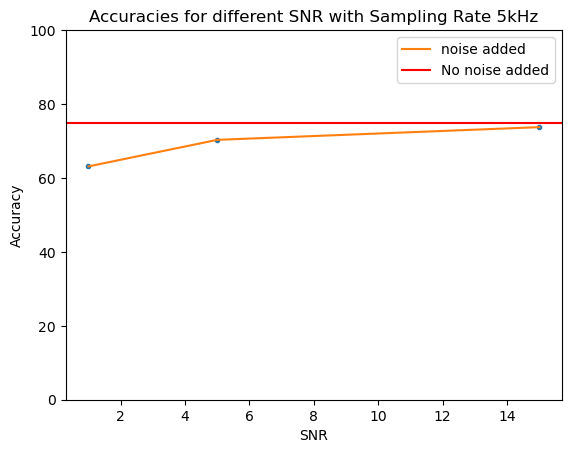

In [71]:
x_snr = [1, 5, 15]
y = [63.125, 70.3125, 73.75]
plt.plot(x_snr,y, '.')
plt.plot(x_snr,y, label='noise added')
plt.axhline(75, color='red', label='No noise added')
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.legend()
plt.title('Accuracies for different SNR with Sampling Rate 5kHz')

#### Explain spectral gating

Text(0.5, 1.0, 'Accuracies for different SNR with Sampling Rate 5kHz')

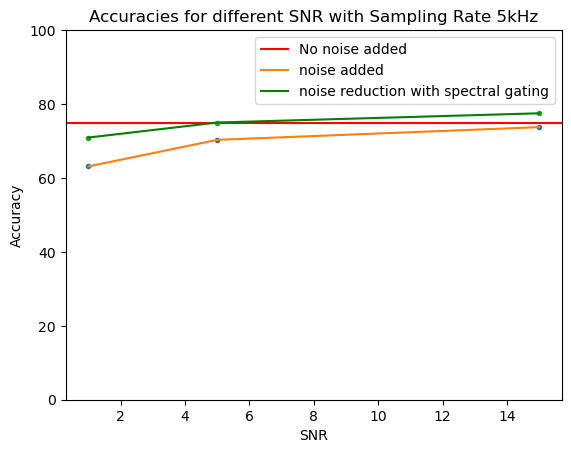

In [76]:
plt.axhline(75, color='red', label='No noise added')

x_snr = [1, 5, 15]
y_snr = [63.125, 70.3125, 73.75]
plt.plot(x_snr,y_snr, '.')
plt.plot(x_snr,y_snr, label='noise added')

x_nr = [1, 5, 15]
y_nr = [70.9375, 75.0, 77.5]
plt.plot(x_nr,y_nr, '.')
plt.plot(x_nr,y_nr, color='green', label='noise reduction with spectral gating')

plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.legend()
plt.title('Accuracies for different SNR with Sampling Rate 5kHz')